In [1]:
%pip install prophet statsmodels pmdarima matplotlib seaborn scikit-learn pandas
# On Windows if prophet fails try: pip install prophet==1.1.4  (or see prophet docs)


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.1 MB 2.2 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.1 MB 4.1 MB/s eta 0:00:03
   ----------- ---------------------------- 3.4/12.1 MB 4.7 MB/s eta 0:00:02
   ----------------- ---------------------- 5.2/12.1 MB 5.6 MB/s eta 0:00:02
   -------------------- ------------------- 6.3/12.1 MB 5.6 MB/s eta 0:00:02
   ------------------------- -------------- 7.9/12.1 MB 5.7 MB/s eta 0:00:01
   -------------------------------- ------- 9.7/12.1 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 11.3/12.1 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------

02:36:20 - cmdstanpy - INFO - Chain [1] start processing
02:36:20 - cmdstanpy - INFO - Chain [1] done processing


Loaded rows: 375913
Time-series length (months): 11
ds
2010-01-01    134.711463
2011-01-01    158.014659
2012-01-01    186.819382
2013-01-01    208.039291
2014-01-01    236.899947
Name: wage, dtype: float64
Train months: 8, Test months: 3

--- Training Prophet (robust) ---
Inferred freq: YS-JAN
Using detected time unit: years; series length after resample: 11
Train points: 9, Test points: 2 (units = years)
Prophet Test MAE: 3.813, RMSE: 4.297

--- Training SARIMA (auto_arima via pmdarima) ---
pmdarima or statsmodels not installed. Skipping SARIMA. Install 'pmdarima statsmodels' to use it.


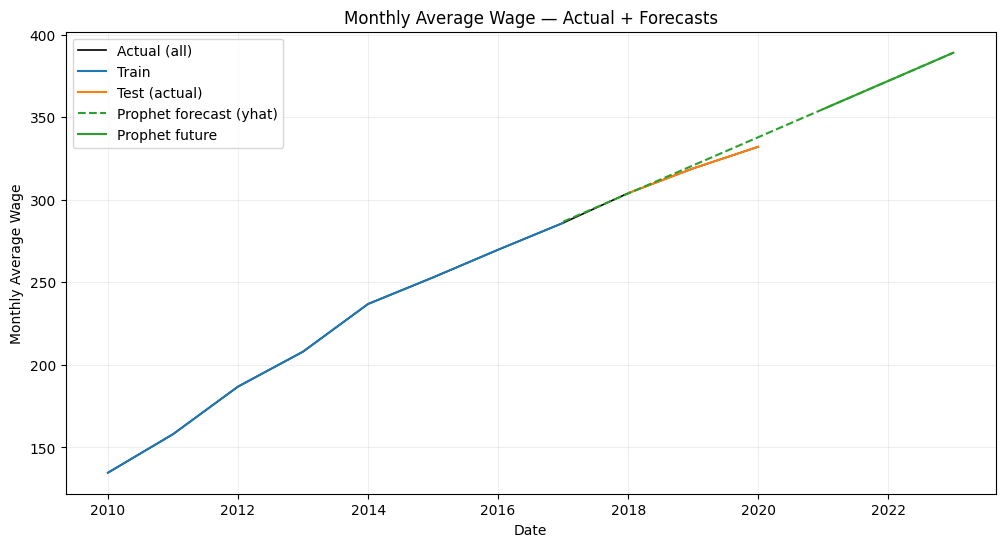


=== Numeric Forecasts (next months) ===
            prophet
2020-02-01   354.95
2020-03-01   354.95
2020-04-01   354.95
2020-05-01   354.95
2020-06-01   354.95
2020-07-01   354.95
2020-08-01   354.95
2020-09-01   354.95
2020-10-01   354.95
2020-11-01   354.95
2020-12-01   354.95
2021-01-01   354.95

Done.


In [12]:
"""
Time-series forecasting for agricultural wages.
- Expects cleaned_agri_wages.csv in same folder.
- Aggregates monthly_average_wage by month-year.
- Trains Prophet and SARIMA, forecasts next N months, plots results.
"""

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Forecast horizon (months)
FORECAST_MONTHS = 12
FILE = "cleaned_agri_wages.csv"

# ----------------- Load & prepare series -----------------
df = pd.read_csv(FILE)
print("Loaded rows:", len(df))

# Attempt to parse a date column. Accept possibilities: 'month', 'date', 'year'+'month'
if "month" in df.columns:
    # try to parse month column (common formats: 'Jan-2020', '2020-01', '01-2020', '2020-01-01')
    df["ds"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
elif ("year" in df.columns) and ("month_name" in df.columns or "month_num" in df.columns):
    # if separate year and month fields exist
    if "month_num" in df.columns:
        df["ds"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month_num"].astype(str).str.zfill(2) + "-01", errors="coerce")
    else:
        # month_name -> convert to month number
        df["ds"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month_name"].astype(str) + "-01", errors="coerce")
elif ("year" in df.columns):
    # fallback: make first of year (annual -> monthly not ideal)
    df["ds"] = pd.to_datetime(df["year"].astype(int).astype(str) + "-01-01", errors="coerce")
else:
    raise ValueError("No parsable date column found. Add a 'month' or 'year'/'month' column.")

# ensure we have numeric wage column
if "monthly_average_wage" not in df.columns:
    raise ValueError("Expected column 'monthly_average_wage' in CSV.")

# Aggregate to monthly series (mean). Change group if needed (e.g., state-wise)
ts = df.groupby(pd.Grouper(key="ds", freq="MS"))["monthly_average_wage"].mean().dropna().sort_index()
ts = ts.rename("wage")
print("Time-series length (months):", len(ts))
print(ts.head())

# If too sparse / short, warn
if len(ts) < 24:
    print("Warning: series is short (<24 months). Models may not generalize well.")

# ----------------- Train/Test split (last N months as test) -----------------
n_test = min( max(3, int(round(len(ts) * 0.2))), 24 )  # 20% or up to 24 months
train = ts.iloc[:-n_test]
test = ts.iloc[-n_test:]
print(f"Train months: {len(train)}, Test months: {len(test)}")

# ----------------- 1) Prophet model -----------------
# ----------------- Prophet Model (Fixed Forecast Alignment) -----------------
# ---------- Robust Prophet training (handles annual/monthly/short series) ----------
use_prophet = True
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception:
        use_prophet = False
        print("Prophet not available. Skipping Prophet model. Install 'prophet' to use it.")

prophet_results = None
if use_prophet:
    print("\n--- Training Prophet (robust) ---")

    # Ensure ts has a DatetimeIndex
    s = ts.copy()
    s = s.sort_index()

    # Infer frequency
    inferred = pd.infer_freq(s.index)
    print("Inferred freq:", inferred)

    # If no freq (sparse), try resampling monthly if plausible
    if inferred is None:
        # if index spacing looks yearly (year boundaries), treat as annual
        year_diff = (s.index[1:] - s.index[:-1]).days.mean() / 365.25
        if year_diff > 0.9:
            freq_type = "A"   # annual
        else:
            freq_type = "MS"  # monthly-ish fallback
    else:
        freq_type = inferred

    # If monthly data is desired but we have gaps, resample to MS and interpolate
    if freq_type.startswith("M") or freq_type.startswith("MS") or freq_type.lower().startswith("m"):
        # ensure monthly index
        s = s.resample("MS").mean()
        # if many missing months, interpolate (linear)
        s = s.interpolate(method="linear", limit_direction="both")
        time_unit = "months"
    else:
        # treat as annual
        s = s.resample("AS").mean()
        s = s.interpolate(method="linear", limit_direction="both")
        time_unit = "years"

    print(f"Using detected time unit: {time_unit}; series length after resample: {len(s)}")

    # rebuild train/test split on s (instead of original ts)
    n_test = min(max(1, int(round(len(s) * 0.2))), 24)
    train_s = s.iloc[:-n_test]
    test_s = s.iloc[-n_test:]
    print(f"Train points: {len(train_s)}, Test points: {len(test_s)} (units = {time_unit})")

    # Prepare prophet DataFrame
    df_p = train_s.reset_index().rename(columns={train_s.name or "wage":"y", "index":"ds"})
    df_p = df_p.rename(columns={df_p.columns[0]:"ds", df_p.columns[1]:"y"})  # ensure names

    # Build Prophet model with safer defaults for short series
    # reduce changepoint sensitivity for short series to avoid big jumps
    cp_scale = 0.05 if len(train_s) < 30 else 0.5
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=cp_scale)
    # Add yearly seasonality only if we have >= 24 points and our unit is monthly or annual
    if time_unit == "months" and len(train_s) >= 24:
        m.add_seasonality(name="yearly", period=12, fourier_order=5)
    if time_unit == "years" and len(train_s) >= 8:
        # for annual series add 1-year cycle is trivial; skip seasonality for annual
        pass

    m.fit(df_p)

    # Build future dataframe in the same frequency as s
    if time_unit == "months":
        total_periods = len(test_s) + FORECAST_MONTHS
        future = m.make_future_dataframe(periods=total_periods, freq="MS")
    else:
        # if annual, forecast next FORECAST_MONTHS years (interpret FORECAST_MONTHS as years)
        total_periods = len(test_s) + max(3, int(np.ceil(FORECAST_MONTHS / 12)))  # at least 3-year horizon
        future = m.make_future_dataframe(periods=total_periods, freq="AS")

    forecast = m.predict(future).set_index("ds")["yhat"]

    # Align the forecast to test_s and future months
    prophet_forecast_test = forecast.reindex(test_s.index).fillna(method="ffill")
    if time_unit == "months":
        future_idx = pd.date_range(start=test_s.index[-1] + pd.offsets.MonthBegin(1), periods=FORECAST_MONTHS, freq="MS")
    else:
        future_idx = pd.date_range(start=test_s.index[-1] + pd.offsets.YearBegin(1), periods=max(3,int(np.ceil(FORECAST_MONTHS/12))), freq="AS")

    prophet_forecast_future = forecast.reindex(future_idx).fillna(method="ffill")

    # Evaluation (if test exists)
    if len(test_s) > 0:
        mae = mean_absolute_error(test_s.values, prophet_forecast_test.values)
        rmse = np.sqrt(mean_squared_error(test_s.values, prophet_forecast_test.values))
        print(f"Prophet Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

    prophet_results = {
        "model": m,
        "forecast_full": forecast,
        "test_pred": prophet_forecast_test,
        "future_pred": prophet_forecast_future,
        "train_index": train_s.index,
        "test_index": test_s.index,
        "resampled_series": s
    }

# ----------------- 2) SARIMA (statsmodels) -----------------
print("\n--- Training SARIMA (auto_arima via pmdarima) ---")
use_sarima = True
try:
    import pmdarima as pm
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except Exception:
    use_sarima = False
    print("pmdarima or statsmodels not installed. Skipping SARIMA. Install 'pmdarima statsmodels' to use it.")

sarima_results = None
if use_sarima:
    # use auto_arima to get reasonable orders
    try:
        auto = pm.auto_arima(train.values, seasonal=True, m=12, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
        order = auto.order
        seasonal_order = auto.seasonal_order
        print("Auto ARIMA order:", order, "seasonal_order:", seasonal_order)
    except Exception as e:
        print("auto_arima failed, using fallback order (1,1,1)(1,1,1,12). Error:", e)
        order = (1,1,1)
        seasonal_order = (1,1,1,12)

    # fit SARIMAX
    try:
        model_sar = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        sar_res = model_sar.fit(disp=False)
        # predict test and future
        sar_test_pred = sar_res.get_forecast(steps=len(test)).predicted_mean if len(test)>0 else pd.Series(dtype=float)
        sar_future_pred = sar_res.get_forecast(steps=len(test)+FORECAST_MONTHS).predicted_mean.iloc[len(test):]  # next months after test
        if len(test)>0:
            mae = mean_absolute_error(test.values, sar_test_pred.values)
            rmse = np.sqrt(mean_squared_error(test.values, sar_test_pred.values))
            print(f"SARIMA Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")
        sarima_results = {
            "model": sar_res,
            "test_pred": sar_test_pred,
            "future_pred": sar_future_pred
        }
    except Exception as e:
        print("SARIMAX fit failed:", e)
        sarima_results = None

# ----------------- Plot combined results -----------------
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Actual (all)", color="black", linewidth=1.2)
plt.plot(train.index, train.values, label="Train", color="tab:blue")
plt.plot(test.index, test.values, label="Test (actual)", color="tab:orange")

if prophet_results is not None:
    # prophet full forecast yhat (safer key handling)
    # prior code stored the full forecast under "forecast_full"
    fcst = prophet_results.get("forecast_full", prophet_results.get("forecast", None))
    # only attempt to plot if we have a valid forecast series
    if fcst is not None and len(fcst) > 0:
        # draw prophet forecast for full future horizon (align)
        # We'll plot prophet predicted values from end of train onward
        start = train.index[-1] if len(train) > 0 else fcst.index[0]
        prophet_plot_series = fcst[start:]  # Start from end of training data
        plt.plot(prophet_plot_series.index, prophet_plot_series.values, 
                 label="Prophet forecast (yhat)", color="tab:green", linestyle="--")

if sarima_results is not None:
    # combine sarima predictions: show test pred and future pred aligned
    if sarima_results["test_pred"] is not None and len(sarima_results["test_pred"])>0:
        plt.plot(test.index, sarima_results["test_pred"].values, label="SARIMA test-pred", color="tab:purple", linestyle=":")
    if sarima_results["future_pred"] is not None and len(sarima_results["future_pred"])>0:
        future_idx = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(1), periods=FORECAST_MONTHS, freq='MS')
        plt.plot(future_idx, sarima_results["future_pred"].values, label="SARIMA future", color="tab:purple")

# Prophet future forecast plotting
if prophet_results is not None and prophet_results["future_pred"] is not None:
    future_idx = prophet_results["future_pred"].index
    plt.plot(future_idx, prophet_results["future_pred"].values, label="Prophet future", color="tab:green")

plt.legend()
plt.title("Monthly Average Wage — Actual + Forecasts")
plt.xlabel("Date")
plt.ylabel("Monthly Average Wage")
plt.grid(alpha=0.2)
plt.show()

# ----------------- Print simple numeric forecast table -----------------
print("\n=== Numeric Forecasts (next months) ===")
future_index = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(1), periods=FORECAST_MONTHS, freq='MS')
df_future = pd.DataFrame(index=future_index)

# Helper to safely extract/reindex series-like forecasts to the expected future_index
def _safe_series_to_index(s):
    if s is None:
        return pd.Series([np.nan] * len(future_index), index=future_index)
    # if it's a Series, reindex to future_index
    if isinstance(s, pd.Series):
        return s.reindex(future_index)
    # otherwise try to convert to a Series; if lengths mismatch, create a Series with NaNs
    try:
        s_series = pd.Series(s)
        if len(s_series) == len(future_index):
            return pd.Series(s_series.values, index=future_index)
        # if s has its own datetime index, try to preserve it
        if isinstance(s, (np.ndarray, list)) and len(s_series) != len(future_index):
            return pd.Series([np.nan] * len(future_index), index=future_index)
    except Exception:
        return pd.Series([np.nan] * len(future_index), index=future_index)
    return pd.Series([np.nan] * len(future_index), index=future_index)

# Prophet column (safe handling when empty or misaligned)
if prophet_results is not None:
    p = prophet_results.get("future_pred", None)
    p_safe = _safe_series_to_index(p)
    # fill small gaps conservatively (optional); keep NaNs if nothing reasonable
    p_safe = p_safe.fillna(method='ffill').fillna(method='bfill')
    df_future["prophet"] = p_safe.values

# SARIMA column (safe handling)
if sarima_results is not None:
    s = sarima_results.get("future_pred", None) if sarima_results else None
    s_safe = _safe_series_to_index(s)
    s_safe = s_safe.fillna(method='ffill').fillna(method='bfill')
    df_future["sarima"] = s_safe.values

print(df_future.round(2))

# ----------------- Save forecasts optionally -----------------
# df_future.to_csv("wage_monthly_forecasts.csv", index_label="month")
print("\nDone.")


In [13]:
# statewise_prophet_forecasts.py
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- CONFIG ----------
FILE = "cleaned_agri_wages.csv"   # update if needed
OUT_DIR = "state_forecasts"
FORECAST_MONTHS = 12
MIN_MONTHS_FOR_FORECAST = 12  # minimum months per state to run reliable monthly forecast
MAKE_PLOTS = True

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- LOAD DATA ----------
df = pd.read_csv(FILE)
print("Loaded rows:", len(df))

# Try to parse a date column into 'ds'
if "month" in df.columns:
    df["ds"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
elif ("year" in df.columns) and ("month_num" in df.columns):
    df["ds"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month_num"].astype(int).astype(str).str.zfill(2) + "-01", errors="coerce")
elif ("year" in df.columns) and ("month_name" in df.columns):
    # month_name like 'Jan', 'February' etc.
    df["ds"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month_name"].astype(str) + "-01", errors="coerce")
else:
    # try to find any date-like column
    date_cols = [c for c in df.columns if "date" in c.lower() or "month" in c.lower()]
    if len(date_cols) > 0:
        df["ds"] = pd.to_datetime(df[date_cols[0]], errors="coerce", dayfirst=True)
    else:
        raise ValueError("No date column found. Make sure you have 'month' or 'year' + 'month' columns.")

# ensure wage column exists
if "monthly_average_wage" not in df.columns:
    raise ValueError("Expected 'monthly_average_wage' column in CSV.")

# Drop rows with bad dates or wages
df = df.dropna(subset=["ds", "monthly_average_wage", "state_name"])
df["monthly_average_wage"] = pd.to_numeric(df["monthly_average_wage"], errors="coerce")
df = df.dropna(subset=["monthly_average_wage"])

# Prophet import (try both names)
use_prophet = True
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception:
        use_prophet = False
        print("Prophet not installed. Install 'prophet' package to run forecasts (pip install prophet).")

if not use_prophet:
    raise SystemExit("Prophet package required. Install it and re-run.")

# Helper: build clean monthly series per state
def build_monthly_series(subdf):
    # aggregate mean monthly wage by month start (MS)
    s = subdf.set_index("ds").resample("MS")["monthly_average_wage"].mean()
    # interpolate missing months if any (conservative)
    s = s.interpolate(method="linear", limit_direction="both")
    return s

# States to loop
states = df["state_name"].unique()
print("Found states:", len(states))

summary = []

for state in sorted(states):
    sub = df[df["state_name"] == state].copy()
    s = build_monthly_series(sub)
    s = s.dropna()
    n_points = len(s)
    print(f"\nState: {state} | points: {n_points}")

    if n_points < 3:
        print(f"  Skipping {state} (too few points: {n_points})")
        summary.append((state, n_points, "skipped"))
        continue

    # Decide if we treat as monthly or annual
    inferred = pd.infer_freq(s.index)
    # If freq not monthly, still resampled to MS above; we treat it as monthly
    # Build train/test split (last ~20% as test, min 1)
    n_test = max(1, int(round(n_points * 0.2)))
    train = s.iloc[:-n_test]
    test = s.iloc[-n_test:]

    # Build prophet dataframe
    df_p = train.reset_index().rename(columns={"ds": "ds", "monthly_average_wage": "y"})
    # Safer defaults for short series
    cp_scale = 0.05 if len(train) < 30 else 0.5
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
                changepoint_prior_scale=cp_scale)
    if len(train) >= 24:
        m.add_seasonality(name="yearly", period=12, fourier_order=5)

    try:
        m.fit(df_p)
    except Exception as e:
        print(f"  Prophet fit failed for {state}: {e}")
        summary.append((state, n_points, "fit_failed"))
        continue

    # Create future dataframe: test length + forecast horizon
    total_periods = len(test) + FORECAST_MONTHS
    future = m.make_future_dataframe(periods=total_periods, freq="MS")
    forecast = m.predict(future).set_index("ds")["yhat"]

    # Align predictions: test and future
    prophet_test_pred = forecast.reindex(test.index).fillna(method="ffill").fillna(method="bfill")
    future_idx = pd.date_range(start=test.index[-1] + pd.offsets.MonthBegin(1), periods=FORECAST_MONTHS, freq="MS")
    prophet_future = forecast.reindex(future_idx).fillna(method="ffill").fillna(method="bfill")

    # Evaluate if test exists
    mae = rmse = None
    if len(test) > 0:
        mae = mean_absolute_error(test.values, prophet_test_pred.values)
        rmse = np.sqrt(mean_squared_error(test.values, prophet_test_pred.values))
        print(f"  Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

    # Save numeric forecast CSV
    out_df = pd.DataFrame({
        "ds": prophet_future.index,
        "yhat": prophet_future.values
    })
    fname = os.path.join(OUT_DIR, f"{state.replace(' ','_')}_forecast.csv")
    out_df.to_csv(fname, index=False)
    print(f"  Saved forecast CSV: {fname}")

    # Plot
    if MAKE_PLOTS:
        plt.figure(figsize=(9,4))
        plt.plot(s.index, s.values, label="Actual", color="black")
        plt.plot(train.index, train.values, label="Train", color="tab:blue")
        plt.plot(test.index, test.values, label="Test (actual)", color="tab:orange")
        plt.plot(forecast.index, forecast.values, '--', label="Prophet (yhat)", color="tab:green", alpha=0.8)
        plt.plot(future_idx, prophet_future.values, '-', label="Prophet future", color="tab:green")
        plt.title(f"{state} — Monthly Avg Wage Forecast")
        plt.xlabel("Date")
        plt.ylabel("Monthly Average Wage")
        plt.legend()
        plt.tight_layout()
        pngname = os.path.join(OUT_DIR, f"{state.replace(' ','_')}_forecast.png")
        plt.savefig(pngname, dpi=150)
        plt.close()
        print(f"  Saved plot: {pngname}")

    summary.append((state, n_points, "ok", mae, rmse))

# Print simple summary
print("\nSummary (state, points, status, MAE, RMSE):")
for row in summary:
    print(row)

print("\nAll done. Forecasts and plots saved into folder:", OUT_DIR)


Loaded rows: 375913
Found states: 21

State: Andhra Pradesh | points: 121


02:41:30 - cmdstanpy - INFO - Chain [1] start processing
02:41:30 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 6.413, RMSE: 7.098
  Saved forecast CSV: state_forecasts\Andhra_Pradesh_forecast.csv


02:41:31 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Andhra_Pradesh_forecast.png

State: Assam | points: 121


02:41:31 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 3.493, RMSE: 3.796
  Saved forecast CSV: state_forecasts\Assam_forecast.csv
  Saved plot: state_forecasts\Assam_forecast.png


02:41:32 - cmdstanpy - INFO - Chain [1] start processing



State: Bihar | points: 121


02:41:32 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 6.544, RMSE: 7.203
  Saved forecast CSV: state_forecasts\Bihar_forecast.csv


02:41:32 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Bihar_forecast.png

State: Chhattisgarh | points: 121


02:41:32 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 5.353, RMSE: 6.420
  Saved forecast CSV: state_forecasts\Chhattisgarh_forecast.csv


02:41:33 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Chhattisgarh_forecast.png

State: Gujarat | points: 121


02:41:33 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 2.908, RMSE: 3.162
  Saved forecast CSV: state_forecasts\Gujarat_forecast.csv


02:41:33 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Gujarat_forecast.png

State: Haryana | points: 121


02:41:34 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 3.890, RMSE: 5.547
  Saved forecast CSV: state_forecasts\Haryana_forecast.csv


02:41:34 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Haryana_forecast.png

State: Himachal Pradesh | points: 121


02:41:34 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 4.004, RMSE: 5.101
  Saved forecast CSV: state_forecasts\Himachal_Pradesh_forecast.csv


02:41:35 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Himachal_Pradesh_forecast.png

State: Jharkhand | points: 121


02:41:35 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 10.840, RMSE: 12.024
  Saved forecast CSV: state_forecasts\Jharkhand_forecast.csv


02:41:35 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Jharkhand_forecast.png

State: Karnataka | points: 121


02:41:36 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 56.413, RMSE: 63.438
  Saved forecast CSV: state_forecasts\Karnataka_forecast.csv
  Saved plot: state_forecasts\Karnataka_forecast.png


02:41:36 - cmdstanpy - INFO - Chain [1] start processing



State: Kerala | points: 121


02:41:36 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 11.717, RMSE: 15.132
  Saved forecast CSV: state_forecasts\Kerala_forecast.csv
  Saved plot: state_forecasts\Kerala_forecast.png


02:41:37 - cmdstanpy - INFO - Chain [1] start processing



State: Madhya Pradesh | points: 121


02:41:37 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 3.017, RMSE: 3.575
  Saved forecast CSV: state_forecasts\Madhya_Pradesh_forecast.csv


02:41:37 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Madhya_Pradesh_forecast.png

State: Maharashtra | points: 121


02:41:38 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 22.205, RMSE: 25.456
  Saved forecast CSV: state_forecasts\Maharashtra_forecast.csv


02:41:38 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Maharashtra_forecast.png

State: Odisha | points: 121


02:41:39 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 9.331, RMSE: 10.391
  Saved forecast CSV: state_forecasts\Odisha_forecast.csv
  Saved plot: state_forecasts\Odisha_forecast.png

State: Punjab | points: 121


02:41:39 - cmdstanpy - INFO - Chain [1] start processing
02:41:39 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 7.522, RMSE: 7.906
  Saved forecast CSV: state_forecasts\Punjab_forecast.csv
  Saved plot: state_forecasts\Punjab_forecast.png

State: Rajasthan | points: 121


02:41:40 - cmdstanpy - INFO - Chain [1] start processing
02:41:40 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 4.743, RMSE: 6.536
  Saved forecast CSV: state_forecasts\Rajasthan_forecast.csv
  Saved plot: state_forecasts\Rajasthan_forecast.png

State: Tamil Nadu | points: 121


02:41:40 - cmdstanpy - INFO - Chain [1] start processing
02:41:41 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 1.327, RMSE: 1.633
  Saved forecast CSV: state_forecasts\Tamil_Nadu_forecast.csv
  Saved plot: state_forecasts\Tamil_Nadu_forecast.png

State: Telangana | points: 121


02:41:41 - cmdstanpy - INFO - Chain [1] start processing
02:41:41 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 5.381, RMSE: 5.883
  Saved forecast CSV: state_forecasts\Telangana_forecast.csv
  Saved plot: state_forecasts\Telangana_forecast.png

State: Tripura | points: 121


02:41:42 - cmdstanpy - INFO - Chain [1] start processing
02:41:42 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 8.592, RMSE: 9.967
  Saved forecast CSV: state_forecasts\Tripura_forecast.csv
  Saved plot: state_forecasts\Tripura_forecast.png


02:41:42 - cmdstanpy - INFO - Chain [1] start processing



State: Uttar Pradesh | points: 121


02:41:42 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 3.110, RMSE: 3.277
  Saved forecast CSV: state_forecasts\Uttar_Pradesh_forecast.csv


02:41:43 - cmdstanpy - INFO - Chain [1] start processing


  Saved plot: state_forecasts\Uttar_Pradesh_forecast.png

State: Uttarakhand | points: 109


02:41:43 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 2.149, RMSE: 2.871
  Saved forecast CSV: state_forecasts\Uttarakhand_forecast.csv
  Saved plot: state_forecasts\Uttarakhand_forecast.png


02:41:43 - cmdstanpy - INFO - Chain [1] start processing



State: West Bengal | points: 121


02:41:44 - cmdstanpy - INFO - Chain [1] done processing


  Test MAE: 7.358, RMSE: 9.988
  Saved forecast CSV: state_forecasts\West_Bengal_forecast.csv
  Saved plot: state_forecasts\West_Bengal_forecast.png

Summary (state, points, status, MAE, RMSE):
('Andhra Pradesh', 121, 'ok', 6.413201500280103, np.float64(7.098085997484417))
('Assam', 121, 'ok', 3.4929772711682667, np.float64(3.7962634784245735))
('Bihar', 121, 'ok', 6.543875912802292, np.float64(7.2032414766536785))
('Chhattisgarh', 121, 'ok', 5.353168698140034, np.float64(6.4202868231469425))
('Gujarat', 121, 'ok', 2.907624634616942, np.float64(3.162422182083101))
('Haryana', 121, 'ok', 3.8903282630539144, np.float64(5.547125626829549))
('Himachal Pradesh', 121, 'ok', 4.003549054050441, np.float64(5.1005067950638825))
('Jharkhand', 121, 'ok', 10.840486419466947, np.float64(12.024154346598015))
('Karnataka', 121, 'ok', 56.41312231167101, np.float64(63.4377269141927))
('Kerala', 121, 'ok', 11.716737975685954, np.float64(15.13197770274462))
('Madhya Pradesh', 121, 'ok', 3.0170575024695503